# XGBoost for Regression

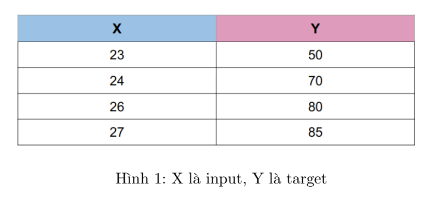

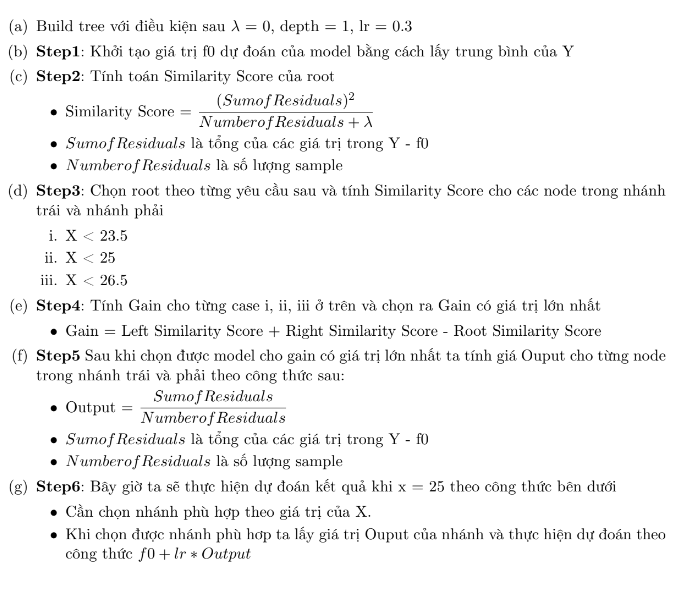

In [23]:
import numpy as np

def cal_similarity_score_regression(arr_y, f0, param_lambda):
  sc = np.sum(arr_y - f0)**2 / (len(arr_y) + param_lambda)
  print("arr_y: ", arr_y, ", mean: ", f0)
  print("arr_y - mean:", arr_y - f0)
  print("sc=", sc)
  return sc

def cal_output_regression(arr_y, f0):
  output = np.sum(arr_y - f0) / len(arr_y)
  print("arr_y: ", arr_y, ", mean: ", f0)
  print("arr_y - mean:", arr_y - f0)
  return output

In [30]:
X = np.array([23,24,26,27])
Y = np.array([50,70,80,85])

# (a) Build tree với điều kiện sau λ = 0, depth = 1, lr = 0.3
param_lambda = 0
param_depth = 1
param_lr = 0.3

print("(b) Step1: Khởi tạo giá trị f0 dự đoán của model bằng cách lấy trung bình của Y")
f0 = np.mean(Y)
print("f0: ", f0)

print("(c) Step2: Tính toán Similarity Score của root")
similarity_score_root = cal_similarity_score_regression(Y, f0, param_lambda)
print("similarity_score_root: ", similarity_score_root)
max_gain = 0
root_node = 0
print("(d) Step3: Chọn root theo từng yêu cầu sau và tính Similarity Score cho các node trong nhánh trái và nhánh phải")
for i in np.array([23.5, 25, 26.5]):
  print("--------------------")
  print("X < ", i, ":")
  print("Left side:")
  left_array = Y[X < i]
  similarity_score_left = cal_similarity_score_regression(left_array, f0, param_lambda)
  print("Right side:")
  right_array = Y[X >= i]
  similarity_score_right = cal_similarity_score_regression(right_array, f0, param_lambda)

  print("(e) Step4: Tính Gain cho từng case i, ii, iii ở trên và chọn ra Gain có giá trị lớn nhất")
  gain = similarity_score_left + similarity_score_right - similarity_score_root
  print("gain: ", gain)
  if gain > max_gain:
    max_gain = gain
    root_node = i

print("\n\nmax gain: ", max_gain)
print("root_node: ", root_node)
print("(f) Step5 Sau khi chọn được model cho gain có giá trị lớn nhất ta tính giá Ouput cho từng node trong nhánh trái và phải")
output_left = cal_output_regression(Y[X < root_node], f0)
output_right = cal_output_regression(Y[X >= root_node], f0)
print("output_left: ", output_left)
print("output_right: ", output_right)

x = 23
print(f"(g) Step6: Bây giờ ta sẽ thực hiện dự đoán kết quả khi x = {x} theo công thức bên dưới")
output = output_left if x < root_node else output_right
print("output: ", output)
yhat = f0 + param_lr * output
print("yhat: ", yhat)
print("residual: ", Y[X==x] - yhat)

(b) Step1: Khởi tạo giá trị f0 dự đoán của model bằng cách lấy trung bình của Y
f0:  71.25
(c) Step2: Tính toán Similarity Score của root
arr_y:  [50 70 80 85] , mean:  71.25
arr_y - mean: [-21.25  -1.25   8.75  13.75]
sc= 0.0
similarity_score_root:  0.0
(d) Step3: Chọn root theo từng yêu cầu sau và tính Similarity Score cho các node trong nhánh trái và nhánh phải
--------------------
X <  23.5 :
Left side:
arr_y:  [50] , mean:  71.25
arr_y - mean: [-21.25]
sc= 451.5625
Right side:
arr_y:  [70 80 85] , mean:  71.25
arr_y - mean: [-1.25  8.75 13.75]
sc= 150.52083333333334
(e) Step4: Tính Gain cho từng case i, ii, iii ở trên và chọn ra Gain có giá trị lớn nhất
gain:  602.0833333333334
--------------------
X <  25.0 :
Left side:
arr_y:  [50 70] , mean:  71.25
arr_y - mean: [-21.25  -1.25]
sc= 253.125
Right side:
arr_y:  [80 85] , mean:  71.25
arr_y - mean: [ 8.75 13.75]
sc= 253.125
(e) Step4: Tính Gain cho từng case i, ii, iii ở trên và chọn ra Gain có giá trị lớn nhất
gain:  506.25
-----

# XGBoost Regressor

Mục tiêu chính của chúng ta là sử dụng mô hình này để giải quyết một bài toán regresion, cụ thể là dự đoán diện tích khu vực bị cháy trong rừng.

## (a) Import các thư viện cần thiết.
Trong đó 'xgboost' là thư viện mà chúng ta sẽ sử dụng để cài đặt và huấn luyện mô hình XGBoost.

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

## (b) Load data để xử lý và phân tích.

In [25]:
dataset_path = '/content/Problem3.csv'
data_df = pd.read_csv(dataset_path)
data_df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,4.468204,26.2,94.3,1.808289,8.2,51,6.7,False,0.000000
1,7,4,oct,tue,4.517431,35.4,669.1,2.041220,18.0,33,0.9,False,0.000000
2,7,4,oct,sat,4.517431,43.7,686.9,2.041220,14.6,33,1.3,False,0.000000
3,8,6,mar,fri,4.529368,33.3,77.5,2.302585,8.3,97,4.0,True,0.000000
4,8,6,mar,sun,4.503137,51.3,102.2,2.360854,11.4,99,1.8,False,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,4,3,aug,sun,4.414010,56.7,665.6,1.064711,27.8,32,2.7,False,2.006871
506,2,4,aug,sun,4.414010,56.7,665.6,1.064711,21.9,71,5.8,False,4.012592
507,7,4,aug,sun,4.414010,56.7,665.6,1.064711,21.2,70,6.7,False,2.498152
508,1,4,aug,sat,4.558079,146.0,614.7,2.509599,25.6,42,4.0,False,0.000000


Trong bài toán dự đoán này, chúng ta quan tâm đến việc ước lượng diện tích khu vực bị cháy trong rừng dựa trên một loạt các thuộc tính được cung cấp. Diện tích khu vực cháy, được lưu trữ trong cột "area", ta sẽ gán giá trị từ cột này vào biến y. Những thuộc tính còn lại sẽ được gán vào biến X.

## (c) Encode category data
Trong data chúng ta nhận thấy rằng sẽ có cột month và day là dạng string và cột rain là dạng bool. Do đó, ta sẽ phải đổi toàn bộ các giá trị này về dạng số.

In [26]:
categorical_cols = data_df.select_dtypes(include=['object', 'bool']).columns.to_list()

for col_name in categorical_cols:
  n_categories = data_df[col_name].nunique()
  print(f'Number of categories in {col_name}: {n_categories}')

ordinal_encoder = OrdinalEncoder()
encoded_categorical_cols = ordinal_encoder.fit_transform(data_df[categorical_cols])
encoded_categorical_df = pd . DataFrame (encoded_categorical_cols, columns = categorical_cols)

numerical_df = data_df.drop(categorical_cols, axis=1)
encoded_df = pd.concat([numerical_df, encoded_categorical_df], axis=1)
encoded_df

Number of categories in month: 12
Number of categories in day: 7
Number of categories in rain: 2


,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,area,month,day,rain
0,7,5,4.468204,26.2,94.3,1.808289,8.2,51,6.7,0.000000,7.0,0.0,0.0
1,7,4,4.517431,35.4,669.1,2.041220,18.0,33,0.9,0.000000,10.0,5.0,0.0
2,7,4,4.517431,43.7,686.9,2.041220,14.6,33,1.3,0.000000,10.0,2.0,0.0
3,8,6,4.529368,33.3,77.5,2.302585,8.3,97,4.0,0.000000,7.0,0.0,1.0
4,8,6,4.503137,51.3,102.2,2.360854,11.4,99,1.8,0.000000,7.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,4,3,4.414010,56.7,665.6,1.064711,27.8,32,2.7,2.006871,1.0,3.0,0.0
506,2,4,4.414010,56.7,665.6,1.064711,21.9,71,5.8,4.012592,1.0,3.0,0.0
507,7,4,4.414010,56.7,665.6,1.064711,21.2,70,6.7,2.498152,1.0,3.0,0.0
508,1,4,4.558079,146.0,614.7,2.509599,25.6,42,4.0,0.000000,1.0,2.0,0.0


## (d) Tách feature parameter and label
Vì bài toán của chúng ta là supervised learning nên tập data train cần có input các đặc trưng (X) và target/label (y), do đó ta sẽ tách các cột dữ liệu thành hai biến X, y. Trong bài toán này target/label là 'area' diện tích cháy rừng

In [27]:
X = encoded_df.drop(columns=['area'])
y = encoded_df['area']

## (e) Tách dữ liệu thành hai tập train/test
Dựa vào bộ dữ liệu gốc, ta cần chia thành hai tập dữ liệu con, một dùng cho việc huấn luyện mô hình và một cho việc đánh giá mô hình. Ở đây, ta sẽ chia theo tỷ lệ 7:3 và tham số ngẫu nhiên random_state = 7:

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

## (f) Xây dựng model XGBoost cho Regression task
Chúng ta xây dựng model với các than số sau seed=7, learning_rate=0.01, n_estimators=102, max_depth=3. Sau đó ta sẽ huấn luyện mô hình với tập data train

In [29]:
xg_reg = xgb.XGBRegressor(seed=7, learning_rate=0.01, n_estimators=102, max_depth=3)
xg_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=102, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## (g) Test mô hình trên tập test data
Để đảm bảo mô hình của chúng ta không chỉ hoạt động tốt trên dữ liệu huấn luyện mà còn có khả năng tổng quát hóa tốt trên dữ liệu mới, việc sử dụng một tập test là rất quan trọng. Tập test này sẽ chứa một phần dữ liệu mà mô hình chưa từng thấy trong quá trình huấn luyện. Đầu tiên, ta cho mô hình đã huấn luyện thực hiện dự đoán trên toàn bộ tập test:

In [30]:
preds = xg_reg.predict(X_test)

## Using MAE & MSE đánh giá mô hình
Để thực hiện đánh giá mô hình trong bài toán regression thì **Mean Absolute Error (MAE)** và **Mean Squared Error (MSE)** là hai trong số những độ đo phổ biến nhất được sử dụng:
1. **Mean Absolute Error (MAE)**: Độ đo này cho chúng ta biết trung bình sự chênh lệch giữa giá trị dự đoán và giá trị thực tế. Nó được tính bằng cách lấy trung bình của trị tuyệt đối của sự khác biệt giữa giá trị dự đoán và giá trị thực sự.

$MAE = \displaystyle\frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$

Trong đó:
* $y_i$ là giá trị thực sự.
* $\hat{y}_i$ là giá trị dự đoán.
* n là số lượng mẫu trong tập dữ liệu.

2. **Mean Squared Error (MSE)**: Tương tự như MAE, nhưng thay vì lấy trị tuyệt đối của sự khác biệt, MSE sẽ lấy bình phương của sự khác biệt. Điều này có nghĩa là các giá trị dự đoán xa giá trị thực tế sẽ bị trừng phạt nặng hơn.

$MSE = \displaystyle\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

Cả hai độ đo này cung cấp góc nhìn khác nhau về hiệu suất của mô hình. MAE cho chúng ta biết sự chênh lệch trung bình giữa dự đoán và thực tế, trong khi MSE tập trung nhiều hơn vào việc trừng phạt các dự đoán sai lệch lớn. Kết hợp cả hai giúp chúng ta có cái nhìn toàn diện hơn về chất lượng của mô hình.

In [33]:
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)

print('Evaluation results on test set:')
print("MAE: ", mae)
print("MSE: ", mse)

Evaluation results on test set:
MAE:  1.1484401341167767
MSE:  1.8845074196256495
